# EuRoC MAV Dataset

- [Link to data website](https://projects.asl.ethz.ch/datasets/doku.php?id=kmavvisualinertialdatasets)
- [PDF about dataset](./ijrr2016_dataset_plain.pdf)

## Platform and Sensors

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&w=900&h=599&tok=87a3d5&media=platform.jpg)

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&w=900&h=720&tok=c9a7a6&media=front_side_gray.jpg)

## Frames

![](https://projects.asl.ethz.ch/datasets/lib/exe/fetch.php?cache=&w=535&h=441&tok=5a6992&media=sensor_setup2.png)

Each sensor has a frame (S) and the transform (T) is between the sensor and the body frame (B).

# Setup

All sensors use SI units except for the time stamps, where are UNIX POSIX integers in nanoseconds with an epic of 1 Jan 1970 0:00 UTC.

- Cameras: 20Hz
- IMU: 200Hz
    - Gyros: rads/sec
    - Accel: m/sec^2

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [28]:
import yaml
import numpy as np
from glob import glob
import cv2
import imageio
import attr
import csv
from collections import namedtuple

In [4]:
def getYaml(file):
    with open(file, 'r') as f:
        doc = yaml.safe_load(f)
    return doc

In [5]:
body = getYaml('body.yaml')
print(body)

{'comment': 'Asctec Firefly MAV'}


In [6]:
class CameraModel(object):
    def __init__(self, file):
        data = getYaml(file)
        self.shape = (data['T_BS']['rows'], data['T_BS']['cols'],)
        self.T_BS = np.array(data['T_BS']['data']).reshape(*self.shape)
        self.D = np.array(data['distortion_coefficients'])
        t = data['intrinsics']
        self.K = np.eye(3)
        self.K[0,0] = t[0]
        self.K[1,1] = t[1]
        self.K[0,2] = t[2]
        self.K[1,2] = t[3]
        self.rate_hz = data['rate_hz']

In [7]:
cam0 = CameraModel('cam0/sensor.yaml')
cam1 = CameraModel('cam1/sensor.yaml')

In [8]:
cam0.T_BS

array([[ 0.01486554, -0.99988093,  0.0041403 , -0.02164015],
       [ 0.99955725,  0.01496721,  0.02571553, -0.06467699],
       [-0.02577444,  0.00375619,  0.99966073,  0.00981073],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [9]:
cam1.T_BS

array([[ 0.01255527, -0.9997551 ,  0.01822377, -0.01984356],
       [ 0.99959878,  0.01301191,  0.02515884,  0.04536894],
       [-0.0253898 ,  0.01790058,  0.99951735,  0.00786212],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [10]:
def getImgs(path):
    files = glob(path)
    print("{} has {} images".format(path, len(files)))
    imgs = []
    timestamps = []
    for f in files:
        ts = int(f.split("/")[2].split(".")[0])
        timestamps.append(ts)
        # im = cv2.imread(f)
        im = imageio.read(f)
        imgs.append(im)
    return imgs, timestamps

In [41]:
left, ts = getImgs("cam0/data/*.png")
right, ts = getImgs("cam1/data/*.png")

cam0/data/*.png has 2912 images
cam1/data/*.png has 2912 images


In [42]:
print(left[0].shape)

(480, 752, 3)


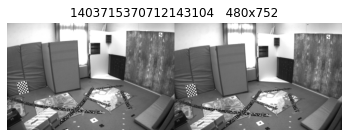

In [12]:
num = 2000
plt.imshow(np.hstack((left[num], right[num])))
title = "{}   {}x{}".format(ts[num],*left[num].shape)
plt.title(title)
plt.axis('off');

```yaml
#Default imu sensor yaml file
sensor_type: imu
comment: VI-Sensor IMU (ADIS16448)

# Sensor extrinsics wrt. the body-frame.
T_BS:
  cols: 4
  rows: 4
  data: [1.0, 0.0, 0.0, 0.0,
         0.0, 1.0, 0.0, 0.0,
         0.0, 0.0, 1.0, 0.0,
         0.0, 0.0, 0.0, 1.0]
rate_hz: 200

# inertial sensor noise model parameters (static)
gyroscope_noise_density: 1.6968e-04     # [ rad / s / sqrt(Hz) ]   ( gyro "white noise" )
gyroscope_random_walk: 1.9393e-05       # [ rad / s^2 / sqrt(Hz) ] ( gyro bias diffusion )
accelerometer_noise_density: 2.0000e-3  # [ m / s^2 / sqrt(Hz) ]   ( accel "white noise" )
accelerometer_random_walk: 3.0000e-3    # [ m / s^3 / sqrt(Hz) ].  ( accel bias diffusion )
```

In [47]:
# use a calibration matrix to undistort an image
def undistort(image, alpha):
    """
    image: an image
    alpha = 0: returns undistored image with minimum unwanted pixels (image
                pixels at corners/edges could be missing)
    alpha = 1: retains all image pixels but there will be black to make up
                for warped image correction
    """
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h,w = image.shape
    mtx = np.array([
        [0.0148655429818, -0.999880929698, 0.00414029679422, -0.0216401454975],
        [0.999557249008, 0.0149672133247, 0.025715529948, -0.064676986768],
        [-0.0257744366974, 0.00375618835797, 0.999660727178, 0.00981073058949],
        [0.0, 0.0, 0.0, 1.0]
    ])
    dist = np.array([-0.28340811, 0.07395907, 0.00019359, 1.76187114e-05])
    # Adjust the calibrations matrix
    # alpha=0: returns undistored image with minimum unwanted pixels (image pixels at corners/edges could be missing)
    # alpha=1: retains all image pixels but there will be black to make up for warped image correction
    # returns new cal matrix and an ROI to crop out the black edges
    newcameramtx, _ = cv2.getOptimalNewCameraMatrix(mtx, dist, (h,w), alpha)
    # undistort
    ret = cv2.undistort(image, mtx, dist, None, newcameramtx)
    return ret

In [48]:
imm = undistort(left[0], 0)

error: OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/core/src/convert_c.cpp:112: error: (-215:Assertion failed) src.size == dst.size && src.channels() == dst.channels() in function 'cvConvertScale'


In [37]:
help(cv2.getOptimalNewCameraMatrix)

Help on built-in function getOptimalNewCameraMatrix:

getOptimalNewCameraMatrix(...)
    getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imageSize, alpha[, newImgSize[, centerPrincipalPoint]]) -> retval, validPixROI
    .   @brief Returns the new camera matrix based on the free scaling parameter.
    .   
    .   @param cameraMatrix Input camera matrix.
    .   @param distCoeffs Input vector of distortion coefficients
    .   \f$(k_1, k_2, p_1, p_2[, k_3[, k_4, k_5, k_6 [, s_1, s_2, s_3, s_4[, \tau_x, \tau_y]]]])\f$ of
    .   4, 5, 8, 12 or 14 elements. If the vector is NULL/empty, the zero distortion coefficients are
    .   assumed.
    .   @param imageSize Original image size.
    .   @param alpha Free scaling parameter between 0 (when all the pixels in the undistorted image are
    .   valid) and 1 (when all the source image pixels are retained in the undistorted image). See
    .   stereoRectify for details.
    .   @param newImgSize Image size after rectification. By default

In [24]:
# making a simple namedtuple to keep track of the data
# Meas = namedtuple('Meas','timestamp gyro accel')

@attr.s(frozen=True, slots=True)
class Meas:
    timestamp = attr.ib()
    gyro = attr.ib()
    accel = attr.ib()
    
def getIMU(filename):
    """
    Based on the diagram above:
        x - up
        y - right wing
        z - forward
    timestamp: nanoseconds
    accel: m/sec^2
    gyro: rad/sec
    """
    data = []
    
    # timestamp [ns],
    # w_RS_S_x [rad s^-1],w_RS_S_y [rad s^-1],w_RS_S_z [rad s^-1],
    # a_RS_S_x [m s^-2],a_RS_S_y [m s^-2],a_RS_S_z [m s^-2]
    with open(filename) as csvfile:
        f = csv.reader(csvfile, delimiter=',')
        g = 9.81
        for i, row in enumerate(f):
            if row[0][0] == '#':
                # print(row)
                continue
            m = Meas(
                float(row[0])*1e-9,
                (float(row[1]),float(row[2]),float(row[3]),),
                (float(row[4])/g,float(row[5])/g,float(row[6])/g,)
            )
            data.append(m)
    start = data[0].timestamp
    stop = data[-1].timestamp
    print(">> Duration: {:.1f} sec".format((stop-start)/1e9))
    print(">> Samples:", len(data))
    print(">> Rate: {:.1f} Hz".format(len(data)/((stop-start)/1e9)))
    return data

In [25]:
imu = getIMU("imu0/data.csv")

>> Duration: 0.0 sec
>> Samples: 29120
>> Rate: 200006868328.4 Hz


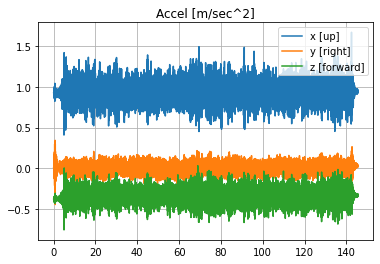

In [27]:
ax=[v.accel[0] for v in imu]
ay=[v.accel[1] for v in imu]
az=[v.accel[2] for v in imu]
ts=[(v.timestamp-imu[0].timestamp) for v in imu]

plt.plot(ts, ax, label='x [up]')
plt.plot(ts, ay, label='y [right]')
plt.plot(ts, az, label='z [forward]')
plt.grid(True)
plt.legend()
plt.title('Accel [m/sec^2]');

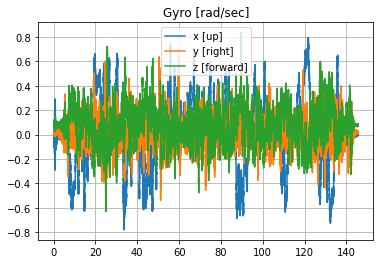

In [115]:
ax=[v.gyro[0] for v in imu]
ay=[v.gyro[1] for v in imu]
az=[v.gyro[2] for v in imu]
ts=[(v.timestamp-imu[0].timestamp)/1e9 for v in imu]

plt.plot(ts, ax, label='x [up]')
plt.plot(ts, ay, label='y [right]')
plt.plot(ts, az, label='z [forward]')
plt.grid(True)
plt.legend()
plt.title('Gyro [rad/sec]');